In [1]:
# import dependencies
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.stats as stats
from datetime import datetime

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to determine the detailed season for a given date
def get_detailed_season(date):
    month = date.month
    if month == 3 or month == 4:
        return 'Early Spring'
    elif month == 5:
        return 'Late Spring'
    elif month == 6 or month == 7:
        return 'Early Summer'
    elif month == 8:
        return 'Late Summer'
    elif month == 9 or month == 10:
        return 'Early Fall'
    elif month == 11:
        return 'Late Fall'
    elif month == 12 or month == 1:
        return 'Early Winter'
    elif month == 2:
        return 'Late Winter'
    
# Function to clean and process a CSV file
def process_csv(file_path):
    df = pd.read_csv(file_path)
    df = df.drop_duplicates().dropna()
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
    df = df.dropna(subset=['last_review'])
    df['detailed_season'] = df['last_review'].apply(get_detailed_season)
    return df

### Filtering out significant outliers

***Filtering out data***
There was so many prices that were significant outliers outside of the standard deviation that we decided to limit the data set to prices of $350 and below per night; to focus on affordable properties/listings.

In [3]:
# Load the cleaned data files
file_path1 = 'Resources/cleaned_airbnb_data.csv'
file_path2 = 'Resources/cleaned_airbnb_listings_usa.csv'

data1 = pd.read_csv(file_path1)
data2 = pd.read_csv(file_path2)

# Combine the datasets
combined_data = pd.concat([data1, data2])

# Ensure the 'last_review' column is in datetime format
combined_data['last_review'] = pd.to_datetime(combined_data['last_review'], errors='coerce')
combined_data = combined_data.dropna(subset=['last_review'])

# Omit listings with a price over 2000
filtered_data = combined_data[combined_data['price'] <= 350]

In [4]:
# Ensure correct order for detailed seasons
season_order = [
    'Early Spring', 'Late Spring', 'Early Summer', 'Late Summer',
    'Early Fall', 'Late Fall', 'Early Winter', 'Late Winter'
]
filtered_data['detailed_season'] = pd.Categorical(
    filtered_data['detailed_season'], categories=season_order, ordered=True
)

# Group and aggregate data by detailed season
seasonal_data = filtered_data.groupby('detailed_season').agg({
    'price': 'mean',
    'number_of_reviews': 'mean',
    'reviews_per_month': 'mean',
    'availability_365': 'mean'
}).reset_index()

In [5]:
# Define colors for each detailed season
season_colors = {
    'Early Spring': 'lightgreen',
    'Late Spring': 'forestgreen',
    'Early Summer': 'skyblue',
    'Late Summer': 'deepskyblue',
    'Early Fall': 'orange',
    'Late Fall': 'darkorange',
    'Early Winter': 'lightgrey',
    'Late Winter': 'darkgrey'
}

# Plot settings
def plot_seasonal_data(seasonal_data, metric, ylabel, title, ax2_label='Average Price (Nightly Rental Cost)'):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax1.bar(seasonal_data['detailed_season'], seasonal_data[metric], color=[season_colors[season] for season in seasonal_data['detailed_season']], edgecolor='black')
    ax1.set_xlabel('Detailed Season', fontsize=14)
    ax1.set_ylabel(ylabel, fontsize=14)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_title(title, fontsize=16)
    
    ax2 = ax1.twinx()
    ax2.plot(seasonal_data['detailed_season'], seasonal_data['price'], color='red', marker='o', linestyle='dashed', linewidth=2, markersize=8)
    ax2.set_ylabel(ax2_label, fontsize=14, color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    fig.tight_layout()
    plt.xticks(rotation=45, fontsize=12)
    plt.show()

# Set plot style
plt.style.use('ggplot')


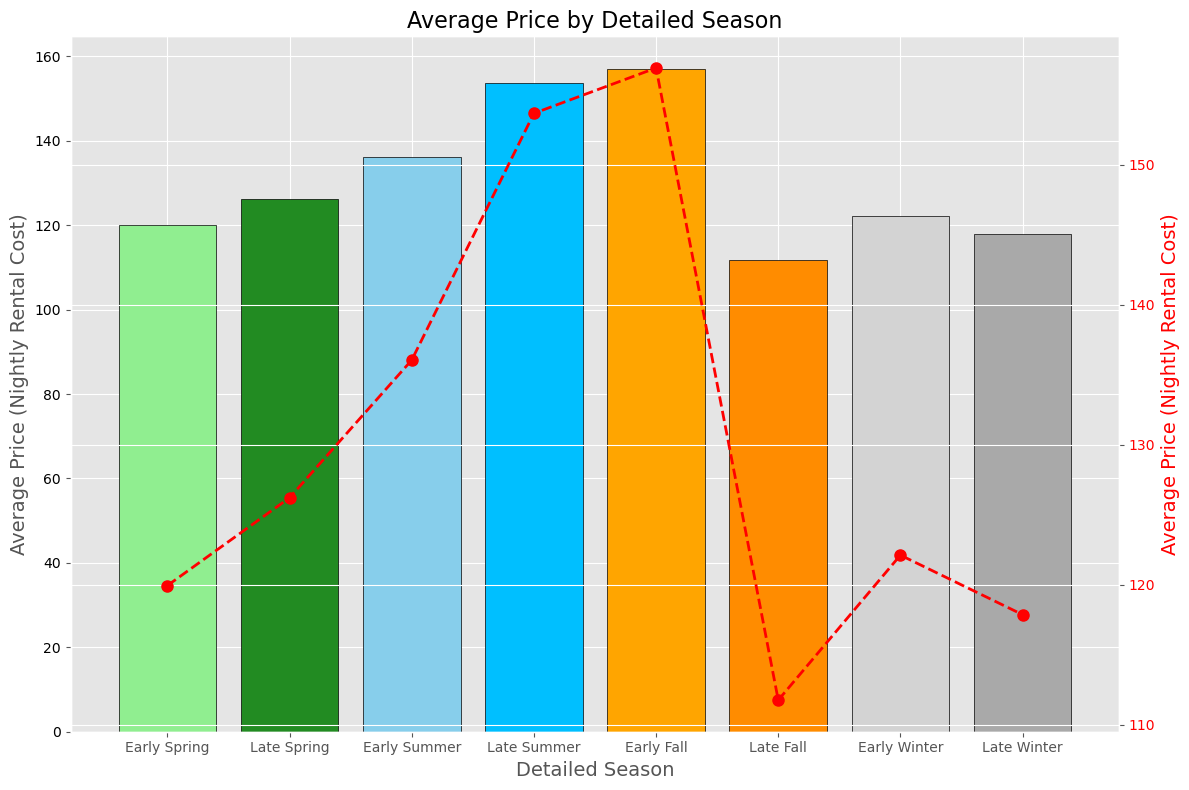

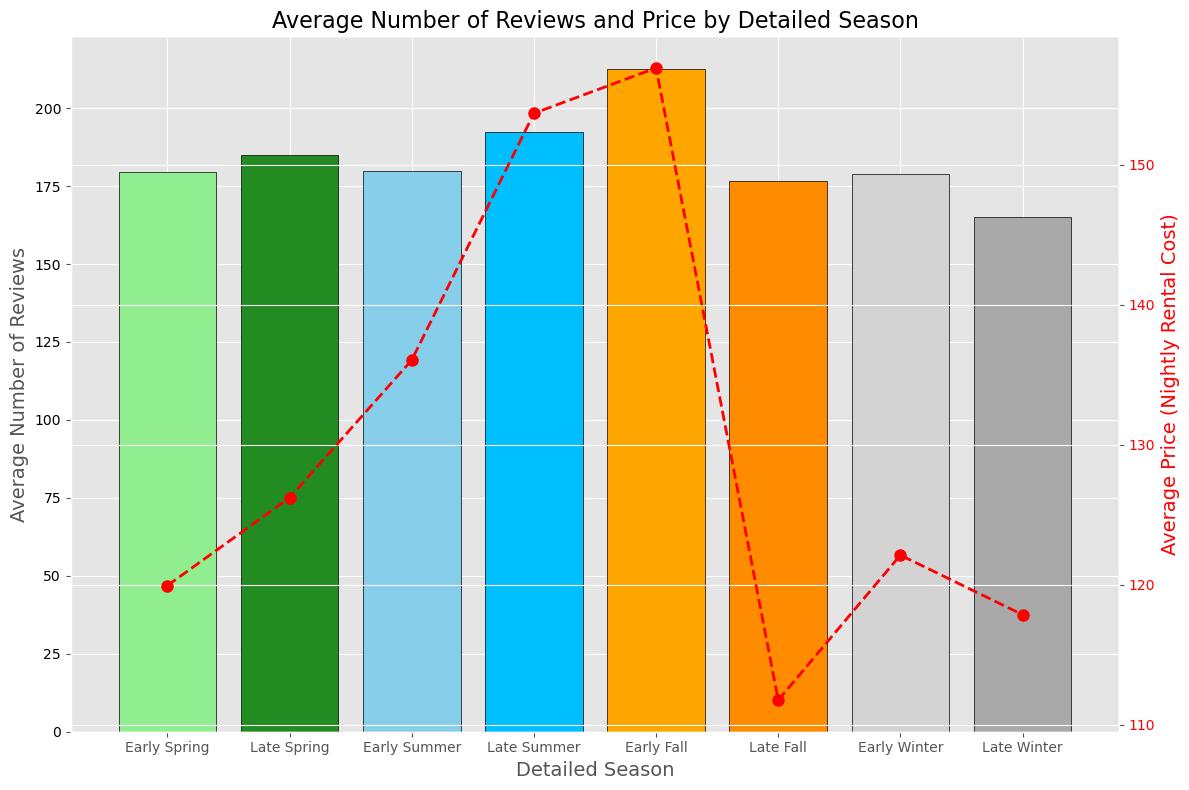

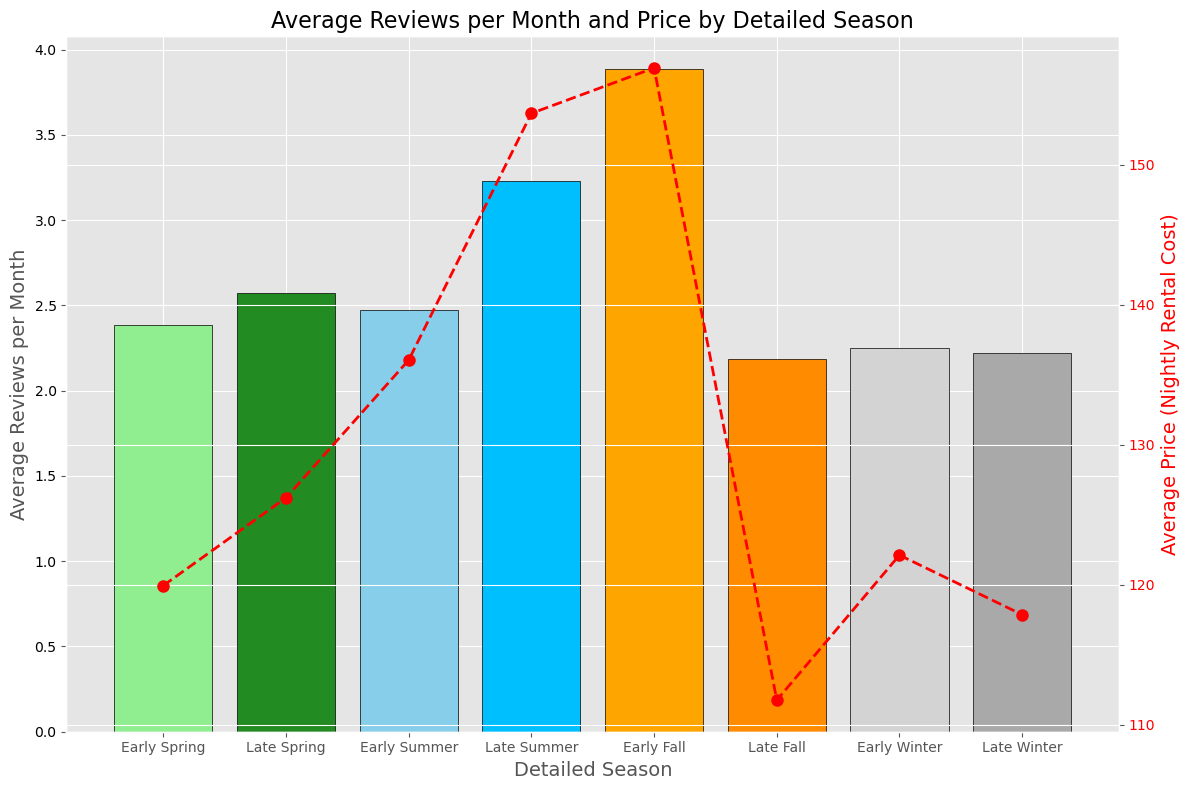

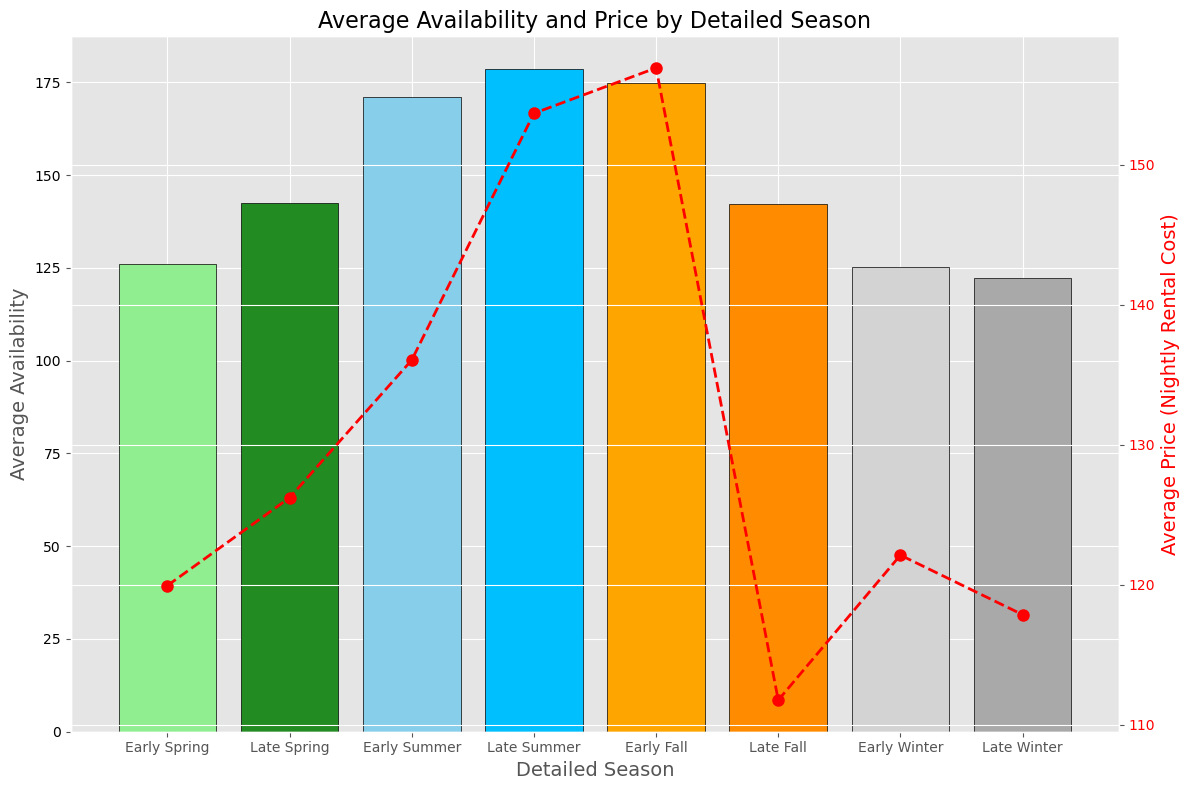

In [6]:
# Plot Average Price by Detailed Season
plot_seasonal_data(seasonal_data, 'price', 'Average Price (Nightly Rental Cost)', 'Average Price by Detailed Season')

# Plot Average Number of Reviews by Detailed Season with Price
plot_seasonal_data(seasonal_data, 'number_of_reviews', 'Average Number of Reviews', 'Average Number of Reviews and Price by Detailed Season')

# Plot Average Reviews per Month by Detailed Season with Price
plot_seasonal_data(seasonal_data, 'reviews_per_month', 'Average Reviews per Month', 'Average Reviews per Month and Price by Detailed Season')

# Plot Average Availability by Detailed Season with Price
plot_seasonal_data(seasonal_data, 'availability_365', 'Average Availability', 'Average Availability and Price by Detailed Season')


<Figure size 1200x800 with 0 Axes>

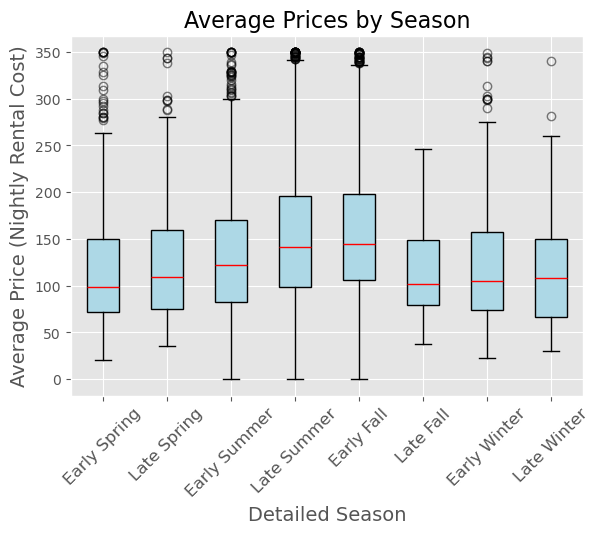

In [7]:
# Box Plot of Average Prices by Season
plt.figure(figsize=(12, 8))
filtered_data.boxplot(column='price', by='detailed_season', patch_artist=True, 
                      boxprops=dict(facecolor='lightblue', color='black'),
                      medianprops=dict(color='red'),
                      whiskerprops=dict(color='black'),
                      capprops=dict(color='black'),
                      flierprops=dict(marker='o', color='red', alpha=0.5))
plt.xlabel('Detailed Season', fontsize=14)
plt.ylabel('Average Price (Nightly Rental Cost)', fontsize=14)
plt.title('Average Prices by Season', fontsize=16)
plt.suptitle('')
plt.xticks(rotation=45, fontsize=12)
plt.show()


In [8]:
# Perform ANOVA tests for each metric
anova_results = {}
for metric in ['price', 'number_of_reviews', 'reviews_per_month', 'availability_365']:
    groups = [filtered_data[filtered_data['detailed_season'] == season][metric].dropna() for season in season_order]
    f_val, p_val = stats.f_oneway(*groups)
    anova_results[metric] = {'f_value': f_val, 'p_value': p_val}

# Display ANOVA test results
print("ANOVA Test Results:")
for metric, results in anova_results.items():
    print(f"{metric.capitalize()}: F-value = {results['f_value']:.2f}, P-value = {results['p_value']:.2e}")
    if results['p_value'] < 0.05:
        print(f"This is statistically significant for {metric}.")

ANOVA Test Results:
Price: F-value = 42.14, P-value = 5.22e-59
This is statistically significant for price.
Number_of_reviews: F-value = 22.15, P-value = 5.99e-30
This is statistically significant for number_of_reviews.
Reviews_per_month: F-value = 78.04, P-value = 7.71e-111
This is statistically significant for reviews_per_month.
Availability_365: F-value = 24.05, P-value = 1.07e-32
This is statistically significant for availability_365.


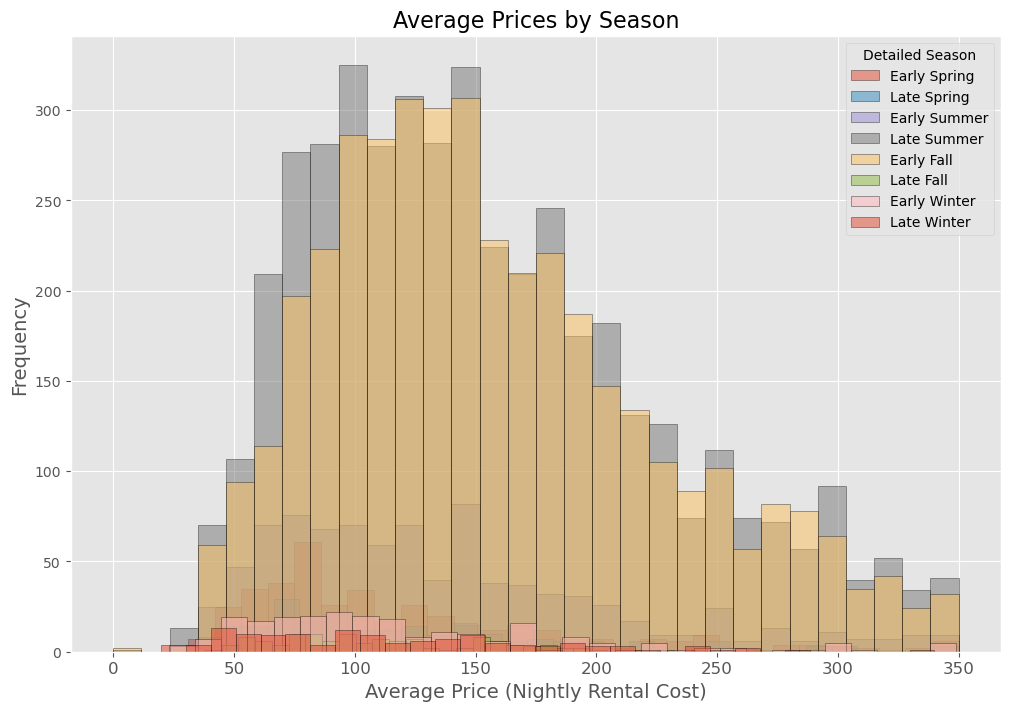

In [27]:
plt.figure(figsize=(12, 8))
for season in season_order: 
  subset = filtered_data[filtered_data['detailed_season'] == season] 
  plt.hist(subset['price'], bins=30, alpha=0.5, label=season, edgecolor='black')
plt.xlabel('Average Price (Nightly Rental Cost)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Detailed Season')
plt.title('Average Prices by Season', fontsize=16)
plt.xticks(fontsize=12)
plt.show()


In [22]:
# Define the season groups to break down into each individual season
spring_seasons = ['Early Spring', 'Late Spring']
summer_seasons = ['Early Summer', 'Late Summer']
fall_seasons = ['Early Fall', 'Late Fall']
winter_seasons = ['Early Winter', 'Late Winter']

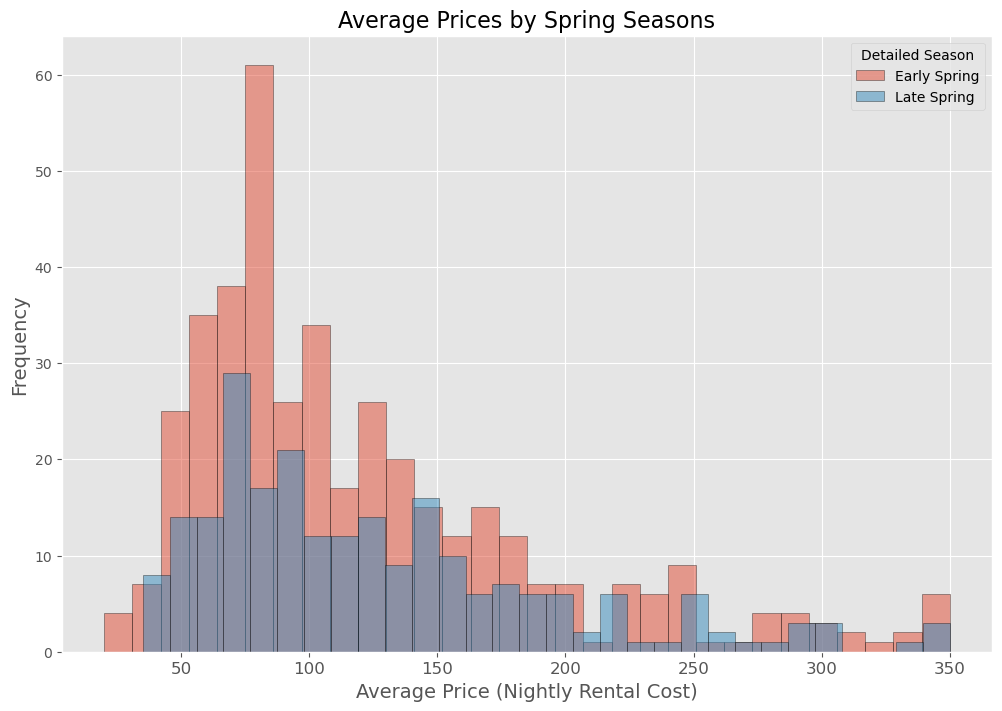

In [23]:
# Plot for Spring seasons
plt.figure(figsize=(12, 8))
for season in spring_seasons:
    subset = filtered_data[filtered_data['detailed_season'] == season]
    plt.hist(subset['price'], bins=30, alpha=0.5, label=season, edgecolor='black')
plt.xlabel('Average Price (Nightly Rental Cost)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Detailed Season')
plt.title('Average Prices by Spring Seasons', fontsize=16)
plt.xticks(fontsize=12)
plt.show()

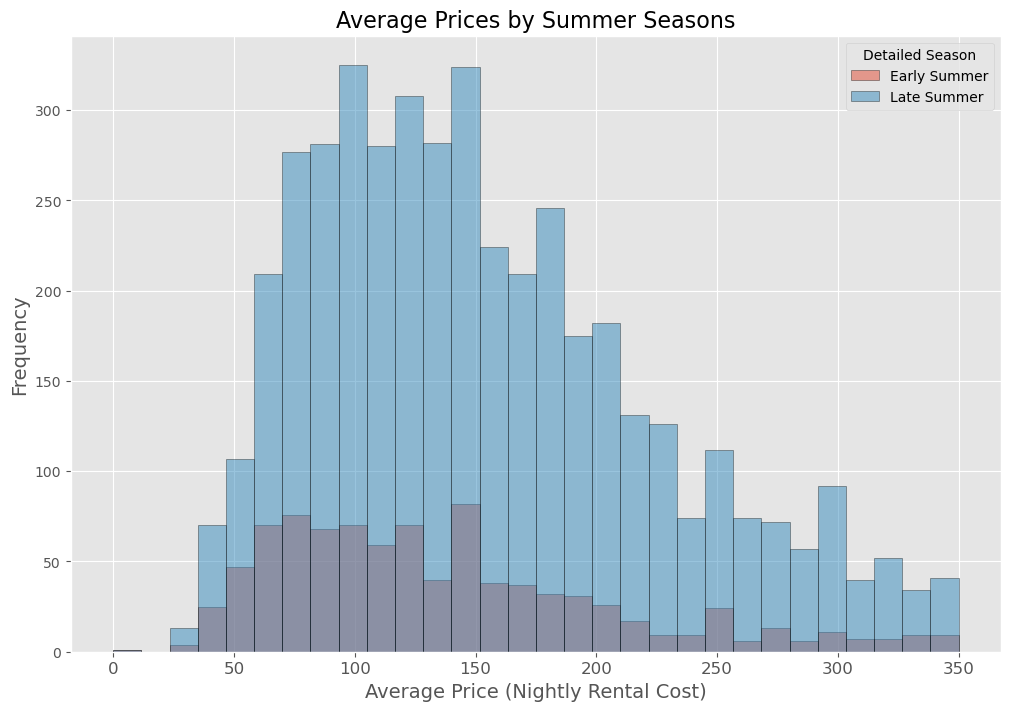

In [24]:
# Plot for Summer seasons
plt.figure(figsize=(12, 8))
for season in summer_seasons:
    subset = filtered_data[filtered_data['detailed_season'] == season]
    plt.hist(subset['price'], bins=30, alpha=0.5, label=season, edgecolor='black')
plt.xlabel('Average Price (Nightly Rental Cost)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Detailed Season')
plt.title('Average Prices by Summer Seasons', fontsize=16)
plt.xticks(fontsize=12)
plt.show()

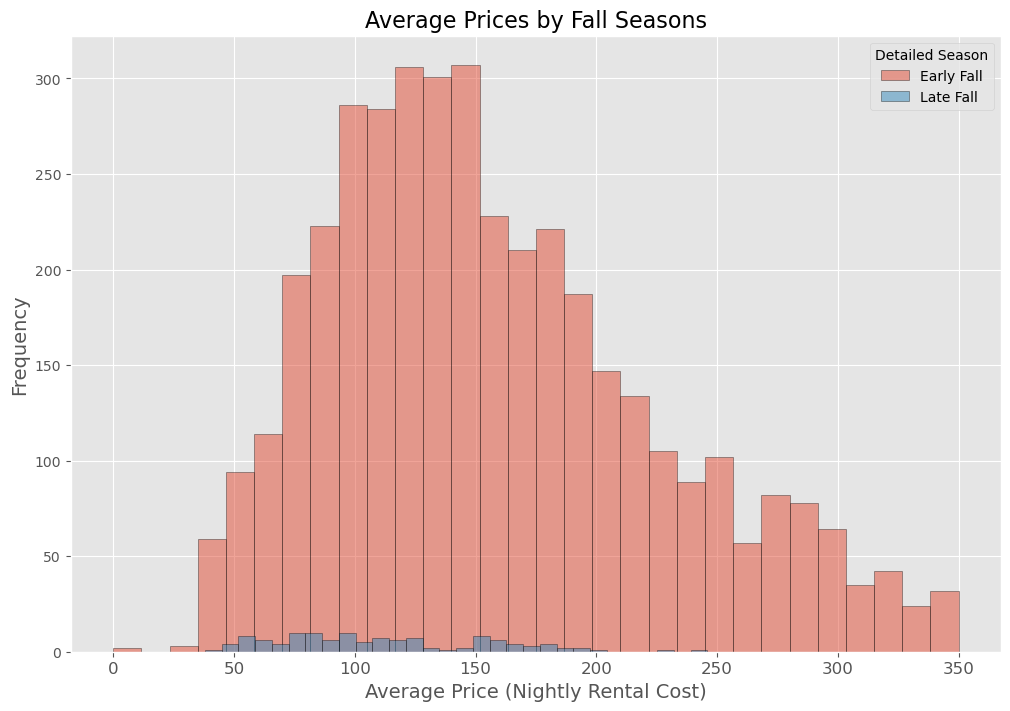

In [25]:
# Plot for Fall seasons
plt.figure(figsize=(12, 8))
for season in fall_seasons:
    subset = filtered_data[filtered_data['detailed_season'] == season]
    plt.hist(subset['price'], bins=30, alpha=0.5, label=season, edgecolor='black')
plt.xlabel('Average Price (Nightly Rental Cost)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Detailed Season')
plt.title('Average Prices by Fall Seasons', fontsize=16)
plt.xticks(fontsize=12)
plt.show()

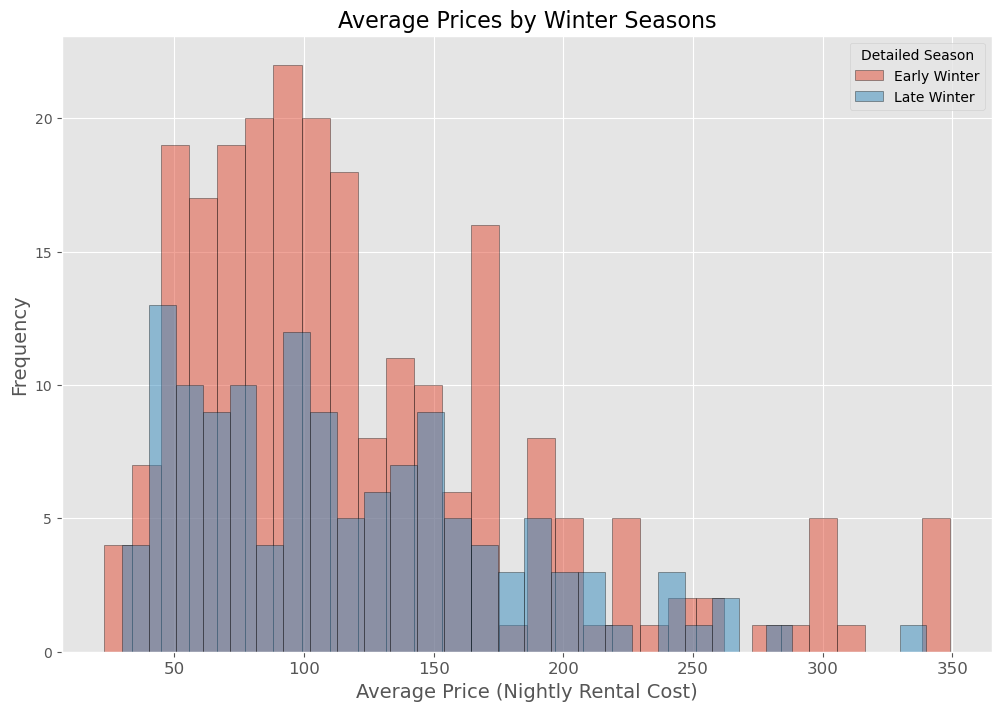

In [26]:
# Plot for Winter seasons
plt.figure(figsize=(12, 8))
for season in winter_seasons:
    subset = filtered_data[filtered_data['detailed_season'] == season]
    plt.hist(subset['price'], bins=30, alpha=0.5, label=season, edgecolor='black')
plt.xlabel('Average Price (Nightly Rental Cost)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Detailed Season')
plt.title('Average Prices by Winter Seasons', fontsize=16)
plt.xticks(fontsize=12)
plt.show()